In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import vehicle_detection as vd
import cv2
import os
import glob
import time
from scipy.ndimage.measurements import label

from random import randint
from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [22]:
import importlib
importlib.reload(vd) 

<module 'vehicle_detection' from '/home/yochanan/Downloads/Udacity/CarND-Vehicle-Detection-master/vehicle_detection_package/vehicle_detection.py'>

In [5]:

car_image = mpimg.imread('../vehicles/vehicles/KITTI_extracted/1010.png')
notcar_image = mpimg.imread('../non-vehicles/non-vehicles/GTI/image1000.png')
plot_side_by_side(images, names)

NameError: name 'plot_side_by_side' is not defined

In [6]:
car_features, notcar_features = vd.get_car_notcar_features()

In [8]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

In [12]:
X.shape

(17760, 3684)

In [13]:
                      
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
scaler_filename = "scaler.pkl"
joblib.dump(X_scaler, scaler_filename)

['scaler.pkl']

In [14]:
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',32,
    'and', 32,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3684


In [15]:
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

9.29 Seconds to train SVC...
Test Accuracy of SVC =  0.9856
My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  1.]
0.00148 Seconds to predict 10 labels with SVC


RGB: (32, 32): 0.9718 (64, 64): 0.9702
HSV: 0.963
YCrCb: 0.9764 # reference to medium article

## Test model prediction 

In [16]:
from keras.layers import Dense, Activation, BatchNormalization
from keras.models import Sequential
from keras.optimizers import adam
from sklearn.utils import shuffle
model = Sequential()
model.add(BatchNormalization(input_shape=(len(X_train[0]),)))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(128, activation='sigmoid'))    
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=adam(lr=0.001), metrics=['accuracy'])
model.save_weights('model_init.h5')

Using TensorFlow backend.


In [17]:
# after checking for overfitting, why not use all the data for training.
history = model.fit(X, y, epochs=6)#, callbacks=callbacks_list)

Epoch 1/6
17760/17760 [==============================] - 7s - loss: 0.0489 - acc: 0.9828     
Epoch 2/6
17760/17760 [==============================] - 7s - loss: 0.0158 - acc: 0.9943     
Epoch 3/6
17760/17760 [==============================] - 7s - loss: 0.0090 - acc: 0.9967     
Epoch 4/6
17760/17760 [==============================] - 7s - loss: 0.0081 - acc: 0.9973     
Epoch 5/6
17760/17760 [==============================] - 7s - loss: 0.0063 - acc: 0.9976     
Epoch 6/6
17760/17760 [==============================] - 7s - loss: 0.0057 - acc: 0.9985     


In [15]:
from keras.models import load_model

model = load_model('model.h5')
model.load_weights("weights.h5")

Using TensorFlow backend.


In [29]:
model.save('model.h5')
model.save_weights('weights.h5')

## vehicle tracker pipeline object

In [28]:
class VehicleTracker:
    def __init__(self, frame_size=(720,1280,3)):
        self.heatmap = []#np.zeros(frame_size)
        self.frames = []
        

    def process_frame(self, frame):
        windows = vd.slide_window()
        hot_windows = vd.search_windows(cv2.cvtColor(frame,cv2.COLOR_RGB2BGR), windows, model, X_scaler, color_space='RGB')
        draw_image = np.copy(frame)
#         self.heatmap = add_heat(self.heatmap, hot_windows)
        # example using heatmap
        new_frame_factor = 0.3
        heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
        
        self.heatmap.append(vd.add_heat(heat, hot_windows))
#         self.heatmap = new_frame_factor * frame + (1-new_frame_factor) * self.heatmap[-3:]
        # do threshold and some kind of detection (blob or cv.contours)
        nb_frames_avg = 7

        if len(self.frames) >= nb_frames_avg:
            heat = new_frame_factor * heat + (1-new_frame_factor) * self.heatmap[-5]
        else:
            heat = vd.apply_threshold(heat, 10)
        heat = np.clip(heat, 0, 255)
        labels = label(heat)
        # example using averaged frame
        self.frames.append(draw_image)

        draw_img = vd.draw_labeled_bboxes(draw_image,labels)
        # do more stuff
        return draw_img

output = 'video_output/test.mp4'

vehicleTracker = VehicleTracker()
clip = VideoFileClip("../videos/project_video.mp4")#.subclip(28,35)
video_clip = clip.fl_image(vehicleTracker.process_frame)
video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video video_output/test.mp4
[MoviePy] Writing video video_output/test.mp4



 99%|█████████▉| 175/176 [06:39<00:02,  2.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/test.mp4 



In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [37]:
test_image = cv2.cvtColor(cv2.imread('../test_images/test4.jpg'),cv2.COLOR_BGR2RGB)

output = vehicleTracker.process_frame(test_image)

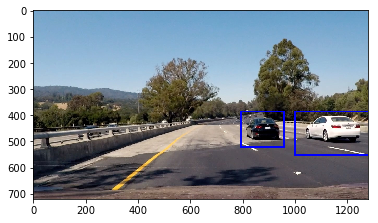

In [39]:
plt.imshow(output)
plt.savefig('output.jpg')
